# OCR for Chinese Characters 

### Links to Datasets: 


http://www.nlpr.ia.ac.cn/databases/Download/competition/competition-gnt.zip
http://www.nlpr.ia.ac.cn/databases/Download/feature_data/HWDB1.1trn_gnt_P1.zip
http://www.nlpr.ia.ac.cn/databases/Download/feature_data/HWDB1.1trn_gnt_P2.zip
http://www.nlpr.ia.ac.cn/databases/download/feature_data/HWDB1.1tst_gnt.zip



### This notebook features open-source code by Lucas Kjaero


- Open-source library used:
https://github.com/lucaskjaero/PyCasia 





- Some code borrowed from: 
https://github.com/lucaskjaero/chinese-character-recognizer


## Methods to load datasets

In [1]:
from math import ceil, floor

import numpy as np
from PIL import Image

__author__ = 'Lucas Kjaero'

TARGET_HEIGHT = 32
TARGET_WIDTH = 32
# Note, in numpy the indexing is opposite cartesian, at (y, x)
TARGET_SHAPE = (TARGET_HEIGHT, TARGET_WIDTH)

def no_processing(image):
    return np.array(image)


def view_resize_and_letterbox(image):
    image_array = resize_and_letterbox(image)
    return Image.fromarray(image_array)


def resize_and_letterbox(image):

    # Default values
    width = image.width
    height = image.height

    x1 = 0
    y1 = 0
    x2 = width
    y2 = height

    # Calculate new dimensions and letterboxing positions
    if width == height:
        new_width, new_height = TARGET_WIDTH, TARGET_HEIGHT
    elif width > height:
        new_height = ceil(TARGET_WIDTH * (height / width))
        new_width = TARGET_WIDTH

        # prepare for letterboxing
        buffer = TARGET_HEIGHT - new_height
        # If there's an extra pixel, add it to the top
        y1 = ceil(buffer / 2)
        y2 = y1 + new_height
    elif width < height:
        new_width = ceil(TARGET_HEIGHT * (width / height))
        new_height = TARGET_HEIGHT

        # prepare for letterboxing
        buffer = TARGET_WIDTH - new_width
        # If there's an extra pixel, add it to the right side.
        x1 = floor(buffer / 2)
        x2 = x1 + new_width

    # Resize the image
    resized_image = image.resize((new_width, new_height))

    # Create a blank background image to paste into
    letterboxed_image = np.zeros(TARGET_SHAPE)
    letterboxed_image.fill(255)

    # Letterbox the image
    image_array = np.array(resized_image)
    letterboxed_image[y1:y2, x1:x2] = image_array

    return letterboxed_image


def process_image(image):
    image_array = np.array(image.resize((32, 32)))

    # Normalize between -1 and 1
    normalized_image_array = image_array / 256

    reshaped_image_array = normalized_image_array.reshape((TARGET_HEIGHT, TARGET_WIDTH, 1))

    return reshaped_image_array

In [2]:
from math import ceil
from os import listdir
from os.path import expanduser, isfile

import numpy as np

from tqdm import tqdm #progress bar

from pycasia.CASIA import CASIA


__author__ = 'Lucas Kjaero'

LABELS_FILE = "labels.txt"
SAMPLES_FILE = "samples.txt"


class CasiaML(CASIA):
    """
    Class to read the dataset for all learning functions.
    """
    def __init__(self, split_percentage=0.2, pre_processing_function=no_processing):
        super().__init__()
        print("Checking for datasets")
        assert self.get_all_datasets() is True, "Datasets aren't properly loaded, " \
                                                "rerun to try again or download datasets manually."

        # Give purposes to the dataset for our own use.
        self.datasets["competition-gnt"]["purpose"] = "train"
        self.datasets["HWDB1.1trn_gnt_P1"]["purpose"] = "train"
        self.datasets["HWDB1.1trn_gnt_P2"]["purpose"] = "train"
        self.datasets["HWDB1.1tst_gnt"]["purpose"] = "test"

        self.training_sets = [dataset for dataset in self.datasets if self.datasets[dataset]["purpose"] == "train"]
        self.testing_sets = [dataset for dataset in self.datasets if self.datasets[dataset]["purpose"] == "test"]

        self.pre_processing_function = pre_processing_function

        # Generate train-validation split
        # split_percentage default is .02
        self.split_percentage = split_percentage 
        self.train_files = []
        self.val_files = []

        for dataset in self.training_sets:
            dataset_path = expanduser(self.base_dataset_path + dataset)
            count = len([name for name in listdir(dataset_path)])
            training_count = ceil((1 - split_percentage) * count)
            val_count = count - training_count

            paths = [dataset_path + "/" + path for path in listdir(dataset_path)]

            train = paths[0:training_count]
            val = paths[training_count:]

            assert len(train) == training_count
            assert len(val) == val_count

            self.train_files.extend(train)
            self.val_files.extend(val)

        # Do one time preprocessing of the dataset's labels and samples
        if not isfile(LABELS_FILE) or not isfile(SAMPLES_FILE):
            labels = []

            print("Generating first-run training set information")
            train_samples_count = 0
            for file in tqdm(self.train_files):
                for image, label in self.load_gnt_file(file):
                    train_samples_count = train_samples_count + 1
                    labels.append(label)

            print("Generating first-run validation set information")
            validation_samples_count = 0
            for file in tqdm(self.val_files):
                for image, label in self.load_gnt_file(file):
                    validation_samples_count = validation_samples_count + 1
                    labels.append(label)

            print("Generating first-run testing set information")
            testing_samples_count = 0
            for dataset in self.testing_sets:
                for image, label in self.load_dataset(dataset):
                    test_samples_count = test_samples_count + 1
                    labels.append(label)

            if not isfile(LABELS_FILE):
                labels_string = "".join(set(labels))
                with open(LABELS_FILE, "w", encoding='utf8') as labels_file:
                    labels_file.write(labels_string)

            if not isfile(SAMPLES_FILE):
                with open(SAMPLES_FILE, "w", encoding='utf8') as samples_file:
                    samples_file.write("train:%s\n" % train_samples_count)
                    samples_file.write("validation:%s\n" % validation_samples_count)
                    samples_file.write("test:%s\n" % test_samples_count)

        # Label count is important for one-hot encoding.
        with open(LABELS_FILE, "r", encoding='utf8') as labels_file:
            self.classes = labels_file.read()
            self.class_count = len(self.classes)

        # Sample count is needed to know how many samples per epoch
        with open(SAMPLES_FILE, "r", encoding='utf8') as samples_file:
            samples_data = samples_file.read().split("\n")
            self.training_sample_count = int(samples_data[0].split(":")[1])
            self.validation_sample_count = int(samples_data[1].split(":")[1])
            self.testing_sample_count = int(samples_data[2].split(":")[1])
            self.total_sample_count = self.training_sample_count + self.validation_sample_count + self.testing_sample_count

        print("Data loaded with %s classes and %s samples" % (self.class_count, self.total_sample_count))
        print("Train: %s, Validation: %s, Testing: %s" % (self.training_sample_count, self.validation_sample_count, self.testing_sample_count))



## Load Datasets

##### Train: 897867, Test: 224310, Validation: 223991


In [3]:
dataset = CasiaML(pre_processing_function=process_image)

Checking for datasets


100%|███████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<?, ?it/s]


Data loaded with 3755 classes and 1346168 samples
Train: 897867, Validation: 224310, Testing: 223991


## Taking a look at all the characters/labels 

In [4]:
#labels file
with open(LABELS_FILE, "r", encoding='utf8') as labels_file:
            label = labels_file.read()

print("number of character labels: ",len(label))

number of character labels:  3755



### We only want to use part of the dataset for classification
- We pick 70 labels/characters


In [10]:
import glob
from IPython.display import display, Image
from io import BytesIO
from PIL import Image as Pil


DIR = r'C:\Users\caryw\CASIA_data\\'
trndir='raw\HWDB1.1trn_gnt_P1\\'
tstdir= "raw\HWDB1.1tst_gnt\\"
valdir='raw\HWDB1.1trn_gnt_P2\\'
directories = [trndir,tstdir,valdir]
label =list(u'祝铰联瑟坑挑研件哀静儒藐瞪拿赡逞疫蜘山舟训圣毁舶煌骂假轮谍榆鼎硅眠朴半迄促绎觅勺戳酵撕盂弘忘砧蝴燎题尧谭订矗襟踪麓规挨恤聪卞丁岔租充各猴缩枚')
X = []

limit = 118
for d in directories:
    foo = []
    for char in label:
        counter = 0
        base = DIR + d + "%s" %char
        for path in glob.glob(base + "\*.jpg"):
            if counter < limit:
                img = Pil.open(path.encode('utf-8'))
                image_array = np.array(img.resize((64, 64)))
                img1 = np.array(image_array)
                foo.append(img1/255)
            counter+=1
    X.append(foo)
    limit=55

print(len(X))
x_trn, x_val, x_tst, Y = X[0],X[1],X[2],label
print("number of labels: ", len(Y))



3
number of labels:  70


In [11]:
print(label)

['祝', '铰', '联', '瑟', '坑', '挑', '研', '件', '哀', '静', '儒', '藐', '瞪', '拿', '赡', '逞', '疫', '蜘', '山', '舟', '训', '圣', '毁', '舶', '煌', '骂', '假', '轮', '谍', '榆', '鼎', '硅', '眠', '朴', '半', '迄', '促', '绎', '觅', '勺', '戳', '酵', '撕', '盂', '弘', '忘', '砧', '蝴', '燎', '题', '尧', '谭', '订', '矗', '襟', '踪', '麓', '规', '挨', '恤', '聪', '卞', '丁', '岔', '租', '充', '各', '猴', '缩', '枚']


In [12]:
print(len(x_trn), len(x_val), len(x_tst))

8260 3850 3850


In [13]:
x_trn, x_val, x_tst = np.asarray(x_trn), np.asarray(x_val), np.asarray(x_tst)


In [14]:
print("training set shape: ",x_trn.shape)
print("validation set shape: ", x_val.shape)
print("testing set shape: ", x_tst.shape)

training set shape:  (8260, 64, 64)
validation set shape:  (3850, 64, 64)
testing set shape:  (3850, 64, 64)


In [15]:
import keras.utils 
num_labels = len(label)

#manually make Y matrix
ytrn = np.array([])
for i in range(num_labels):
    f = [i]*118
    ytrn = np.append(ytrn,f)

ytrn = ytrn.reshape(num_labels*118,1)


ytst = np.array([])
for i in range(num_labels):
    g = [i]*55
    ytst = np.append(ytst,g)

ytst = ytst.reshape(num_labels*55,1)


    


### Generate Shuffled Training, Validation, Testing datasets

In [19]:
from PIL import Image
import pandas as pd 
import matplotlib.pyplot as plot
from sklearn.utils import shuffle


X_trn_shuffled,Y_trn_shuffled = shuffle(x_trn, ytrn)
X_val_shuffled,Y_val_shuffled = shuffle(x_val, ytst)
X_tst_shuffled,Y_tst_shuffled = shuffle(x_tst, ytst)



[9.]
静


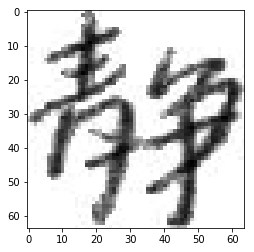

In [20]:
plot.imshow(X_trn_shuffled[1],cmap='gray')
print(Y_trn_shuffled[1])
print(label[int(Y_trn_shuffled[1])])

In [21]:
from keras.utils import to_categorical


X_train = X_trn_shuffled.reshape(8260, 64, 64, 1)
X_val = X_val_shuffled.reshape(3850, 64, 64, 1)
X_test = X_tst_shuffled.reshape(3850, 64, 64, 1)

Y_train = to_categorical(Y_trn_shuffled)
Y_val = to_categorical(Y_val_shuffled)
Y_test = to_categorical(Y_tst_shuffled)
print("success")

success


# Neural Network Model Using Keras

In [22]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras import layers

In [23]:
model = Sequential()

model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(64,64,1)))
model.add(layers.MaxPool2D((2,2)))
    
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(layers.MaxPool2D((2,2)))
    
    
model.add(Dropout(.15))
model.add(Flatten())

model.add(Dense(70, activation='softmax'))

In [24]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
batch_size = 10
datagen = ImageDataGenerator(
        zoom_range=0.2, # randomly zoom into images
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
 
# Fit the model on the batches generated by datagen.flow().
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                              steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
                              epochs=8,
                              validation_data=(X_val, Y_val))

Epoch 1/8


203/826 [======>.......................] - ETA: 32:29 - loss: 4.2724 - acc: 0.0000e+ - ETA: 17:53 - loss: 4.2973 - acc: 0.0000e+ - ETA: 12:50 - loss: 4.4915 - acc: 0.0000e+ - ETA: 10:35 - loss: 4.4402 - acc: 0.0000e+ - ETA: 8:58 - loss: 4.4027 - acc: 0.0000e+00 - ETA: 8:13 - loss: 4.3805 - acc: 0.0167    - ETA: 7:27 - loss: 4.3422 - acc: 0.014 - ETA: 6:54 - loss: 4.3499 - acc: 0.012 - ETA: 6:32 - loss: 4.3367 - acc: 0.011 - ETA: 6:11 - loss: 4.3427 - acc: 0.010 - ETA: 5:52 - loss: 4.3298 - acc: 0.009 - ETA: 5:34 - loss: 4.3289 - acc: 0.008 - ETA: 5:28 - loss: 4.3266 - acc: 0.007 - ETA: 5:20 - loss: 4.3240 - acc: 0.007 - ETA: 5:10 - loss: 4.3189 - acc: 0.006 - ETA: 5:03 - loss: 4.3166 - acc: 0.006 - ETA: 4:57 - loss: 4.3133 - acc: 0.005 - ETA: 4:50 - loss: 4.3089 - acc: 0.005 - ETA: 4:44 - loss: 4.3054 - acc: 0.005 - ETA: 4:41 - loss: 4.3017 - acc: 0.015 - ETA: 4:37 - loss: 4.2946 - acc: 0.019 - ETA: 4:32 - loss: 4.2913 - acc: 0.018 - ETA: 4:27 - loss: 4.2920 - acc: 0.017 - ETA: 4:23 - 

407/826 [=============>................] - ETA: 2:34 - loss: 4.2590 - acc: 0.015 - ETA: 2:34 - loss: 4.2590 - acc: 0.015 - ETA: 2:34 - loss: 4.2590 - acc: 0.015 - ETA: 2:33 - loss: 4.2589 - acc: 0.015 - ETA: 2:33 - loss: 4.2590 - acc: 0.015 - ETA: 2:33 - loss: 4.2590 - acc: 0.015 - ETA: 2:32 - loss: 4.2590 - acc: 0.015 - ETA: 2:32 - loss: 4.2589 - acc: 0.015 - ETA: 2:32 - loss: 4.2589 - acc: 0.015 - ETA: 2:32 - loss: 4.2588 - acc: 0.015 - ETA: 2:32 - loss: 4.2588 - acc: 0.015 - ETA: 2:31 - loss: 4.2587 - acc: 0.014 - ETA: 2:31 - loss: 4.2587 - acc: 0.014 - ETA: 2:31 - loss: 4.2587 - acc: 0.014 - ETA: 2:30 - loss: 4.2586 - acc: 0.014 - ETA: 2:30 - loss: 4.2585 - acc: 0.014 - ETA: 2:30 - loss: 4.2585 - acc: 0.014 - ETA: 2:30 - loss: 4.2585 - acc: 0.014 - ETA: 2:29 - loss: 4.2585 - acc: 0.014 - ETA: 2:29 - loss: 4.2584 - acc: 0.014 - ETA: 2:29 - loss: 4.2584 - acc: 0.014 - ETA: 2:28 - loss: 4.2584 - acc: 0.014 - ETA: 2:28 - loss: 4.2583 - acc: 0.015 - ETA: 2:28 - loss: 4.2582 - acc: 0.015

613/826 [=====================>........] - ETA: 1:40 - loss: 4.2438 - acc: 0.016 - ETA: 1:40 - loss: 4.2431 - acc: 0.016 - ETA: 1:40 - loss: 4.2427 - acc: 0.016 - ETA: 1:40 - loss: 4.2424 - acc: 0.016 - ETA: 1:39 - loss: 4.2422 - acc: 0.016 - ETA: 1:39 - loss: 4.2415 - acc: 0.016 - ETA: 1:39 - loss: 4.2415 - acc: 0.016 - ETA: 1:39 - loss: 4.2411 - acc: 0.016 - ETA: 1:38 - loss: 4.2411 - acc: 0.016 - ETA: 1:38 - loss: 4.2402 - acc: 0.017 - ETA: 1:38 - loss: 4.2399 - acc: 0.017 - ETA: 1:38 - loss: 4.2403 - acc: 0.017 - ETA: 1:37 - loss: 4.2400 - acc: 0.017 - ETA: 1:37 - loss: 4.2401 - acc: 0.017 - ETA: 1:37 - loss: 4.2400 - acc: 0.017 - ETA: 1:37 - loss: 4.2401 - acc: 0.017 - ETA: 1:36 - loss: 4.2399 - acc: 0.017 - ETA: 1:36 - loss: 4.2397 - acc: 0.017 - ETA: 1:36 - loss: 4.2395 - acc: 0.017 - ETA: 1:36 - loss: 4.2391 - acc: 0.017 - ETA: 1:35 - loss: 4.2386 - acc: 0.018 - ETA: 1:35 - loss: 4.2387 - acc: 0.017 - ETA: 1:35 - loss: 4.2382 - acc: 0.017 - ETA: 1:34 - loss: 4.2379 - acc: 0.017

826/826 [==============================] - ETA: 50s - loss: 3.9836 - acc: 0.06 - ETA: 50s - loss: 3.9810 - acc: 0.06 - ETA: 49s - loss: 3.9782 - acc: 0.06 - ETA: 49s - loss: 3.9751 - acc: 0.07 - ETA: 49s - loss: 3.9728 - acc: 0.07 - ETA: 49s - loss: 3.9715 - acc: 0.07 - ETA: 49s - loss: 3.9705 - acc: 0.07 - ETA: 48s - loss: 3.9668 - acc: 0.07 - ETA: 48s - loss: 3.9638 - acc: 0.07 - ETA: 48s - loss: 3.9612 - acc: 0.07 - ETA: 48s - loss: 3.9587 - acc: 0.07 - ETA: 47s - loss: 3.9560 - acc: 0.07 - ETA: 47s - loss: 3.9541 - acc: 0.07 - ETA: 47s - loss: 3.9510 - acc: 0.07 - ETA: 47s - loss: 3.9494 - acc: 0.07 - ETA: 46s - loss: 3.9477 - acc: 0.07 - ETA: 46s - loss: 3.9467 - acc: 0.07 - ETA: 46s - loss: 3.9439 - acc: 0.07 - ETA: 46s - loss: 3.9423 - acc: 0.07 - ETA: 45s - loss: 3.9407 - acc: 0.07 - ETA: 45s - loss: 3.9391 - acc: 0.07 - ETA: 45s - loss: 3.9370 - acc: 0.07 - ETA: 45s - loss: 3.9339 - acc: 0.07 - ETA: 45s - loss: 3.9316 - acc: 0.07 - ETA: 44s - loss: 3.9298 - acc: 0.07 - ETA: 44

204/826 [======>.......................] - ETA: 2:30 - loss: 2.8985 - acc: 0.300 - ETA: 3:07 - loss: 2.1940 - acc: 0.550 - ETA: 2:58 - loss: 2.3254 - acc: 0.466 - ETA: 3:02 - loss: 2.2159 - acc: 0.500 - ETA: 3:00 - loss: 2.1073 - acc: 0.480 - ETA: 3:02 - loss: 2.1818 - acc: 0.483 - ETA: 3:04 - loss: 2.1531 - acc: 0.485 - ETA: 3:01 - loss: 2.0755 - acc: 0.475 - ETA: 3:02 - loss: 2.0468 - acc: 0.500 - ETA: 3:01 - loss: 2.0939 - acc: 0.480 - ETA: 2:59 - loss: 2.1443 - acc: 0.481 - ETA: 2:59 - loss: 2.1872 - acc: 0.466 - ETA: 2:59 - loss: 2.1503 - acc: 0.469 - ETA: 2:57 - loss: 2.1357 - acc: 0.457 - ETA: 2:54 - loss: 2.1251 - acc: 0.446 - ETA: 2:55 - loss: 2.1557 - acc: 0.437 - ETA: 2:57 - loss: 2.1325 - acc: 0.447 - ETA: 2:57 - loss: 2.1416 - acc: 0.444 - ETA: 3:00 - loss: 2.1270 - acc: 0.442 - ETA: 2:59 - loss: 2.1033 - acc: 0.450 - ETA: 3:02 - loss: 2.1352 - acc: 0.452 - ETA: 3:02 - loss: 2.1634 - acc: 0.450 - ETA: 3:02 - loss: 2.1562 - acc: 0.452 - ETA: 3:03 - loss: 2.1563 - acc: 0.454

408/826 [=============>................] - ETA: 2:24 - loss: 2.0085 - acc: 0.476 - ETA: 2:24 - loss: 2.0075 - acc: 0.477 - ETA: 2:23 - loss: 2.0054 - acc: 0.477 - ETA: 2:23 - loss: 2.0043 - acc: 0.478 - ETA: 2:23 - loss: 2.0021 - acc: 0.478 - ETA: 2:23 - loss: 2.0054 - acc: 0.479 - ETA: 2:23 - loss: 2.0046 - acc: 0.479 - ETA: 2:22 - loss: 2.0057 - acc: 0.480 - ETA: 2:22 - loss: 2.0031 - acc: 0.480 - ETA: 2:22 - loss: 2.0094 - acc: 0.479 - ETA: 2:22 - loss: 2.0086 - acc: 0.479 - ETA: 2:21 - loss: 2.0109 - acc: 0.478 - ETA: 2:21 - loss: 2.0100 - acc: 0.478 - ETA: 2:21 - loss: 2.0108 - acc: 0.478 - ETA: 2:21 - loss: 2.0091 - acc: 0.479 - ETA: 2:20 - loss: 2.0104 - acc: 0.478 - ETA: 2:20 - loss: 2.0093 - acc: 0.478 - ETA: 2:20 - loss: 2.0073 - acc: 0.480 - ETA: 2:20 - loss: 2.0052 - acc: 0.480 - ETA: 2:19 - loss: 2.0071 - acc: 0.480 - ETA: 2:19 - loss: 2.0101 - acc: 0.480 - ETA: 2:19 - loss: 2.0111 - acc: 0.480 - ETA: 2:18 - loss: 2.0133 - acc: 0.479 - ETA: 2:18 - loss: 2.0085 - acc: 0.479

615/826 [=====================>........] - ETA: 1:36 - loss: 1.9041 - acc: 0.508 - ETA: 1:36 - loss: 1.9047 - acc: 0.508 - ETA: 1:36 - loss: 1.9050 - acc: 0.508 - ETA: 1:36 - loss: 1.9056 - acc: 0.508 - ETA: 1:35 - loss: 1.9051 - acc: 0.508 - ETA: 1:35 - loss: 1.9054 - acc: 0.508 - ETA: 1:35 - loss: 1.9072 - acc: 0.507 - ETA: 1:35 - loss: 1.9076 - acc: 0.507 - ETA: 1:34 - loss: 1.9060 - acc: 0.507 - ETA: 1:34 - loss: 1.9080 - acc: 0.506 - ETA: 1:34 - loss: 1.9066 - acc: 0.507 - ETA: 1:34 - loss: 1.9059 - acc: 0.507 - ETA: 1:33 - loss: 1.9056 - acc: 0.508 - ETA: 1:33 - loss: 1.9044 - acc: 0.508 - ETA: 1:33 - loss: 1.9036 - acc: 0.508 - ETA: 1:33 - loss: 1.9013 - acc: 0.508 - ETA: 1:33 - loss: 1.9005 - acc: 0.508 - ETA: 1:32 - loss: 1.8983 - acc: 0.509 - ETA: 1:32 - loss: 1.8973 - acc: 0.509 - ETA: 1:32 - loss: 1.8971 - acc: 0.510 - ETA: 1:32 - loss: 1.8976 - acc: 0.509 - ETA: 1:31 - loss: 1.8960 - acc: 0.510 - ETA: 1:31 - loss: 1.8959 - acc: 0.510 - ETA: 1:31 - loss: 1.8980 - acc: 0.510

826/826 [==============================] - ETA: 48s - loss: 1.8394 - acc: 0.52 - ETA: 47s - loss: 1.8401 - acc: 0.52 - ETA: 47s - loss: 1.8386 - acc: 0.52 - ETA: 47s - loss: 1.8367 - acc: 0.52 - ETA: 47s - loss: 1.8360 - acc: 0.52 - ETA: 46s - loss: 1.8349 - acc: 0.52 - ETA: 46s - loss: 1.8360 - acc: 0.52 - ETA: 46s - loss: 1.8358 - acc: 0.52 - ETA: 46s - loss: 1.8350 - acc: 0.52 - ETA: 45s - loss: 1.8346 - acc: 0.52 - ETA: 45s - loss: 1.8341 - acc: 0.52 - ETA: 45s - loss: 1.8333 - acc: 0.52 - ETA: 45s - loss: 1.8320 - acc: 0.52 - ETA: 45s - loss: 1.8332 - acc: 0.52 - ETA: 44s - loss: 1.8334 - acc: 0.52 - ETA: 44s - loss: 1.8330 - acc: 0.52 - ETA: 44s - loss: 1.8320 - acc: 0.52 - ETA: 44s - loss: 1.8317 - acc: 0.52 - ETA: 43s - loss: 1.8311 - acc: 0.52 - ETA: 43s - loss: 1.8309 - acc: 0.52 - ETA: 43s - loss: 1.8297 - acc: 0.52 - ETA: 43s - loss: 1.8283 - acc: 0.52 - ETA: 43s - loss: 1.8283 - acc: 0.52 - ETA: 42s - loss: 1.8273 - acc: 0.52 - ETA: 42s - loss: 1.8257 - acc: 0.52 - ETA: 42

204/826 [======>.......................] - ETA: 3:28 - loss: 1.6709 - acc: 0.500 - ETA: 3:13 - loss: 1.1612 - acc: 0.650 - ETA: 3:00 - loss: 1.1027 - acc: 0.666 - ETA: 3:16 - loss: 1.2900 - acc: 0.575 - ETA: 3:10 - loss: 1.2577 - acc: 0.640 - ETA: 3:03 - loss: 1.2423 - acc: 0.616 - ETA: 3:09 - loss: 1.2863 - acc: 0.614 - ETA: 3:05 - loss: 1.3127 - acc: 0.625 - ETA: 3:01 - loss: 1.2679 - acc: 0.633 - ETA: 2:57 - loss: 1.3610 - acc: 0.630 - ETA: 2:56 - loss: 1.3591 - acc: 0.636 - ETA: 2:55 - loss: 1.4114 - acc: 0.625 - ETA: 2:59 - loss: 1.4064 - acc: 0.615 - ETA: 3:00 - loss: 1.4278 - acc: 0.614 - ETA: 2:57 - loss: 1.3927 - acc: 0.626 - ETA: 2:55 - loss: 1.3455 - acc: 0.637 - ETA: 2:53 - loss: 1.3225 - acc: 0.641 - ETA: 2:52 - loss: 1.3165 - acc: 0.638 - ETA: 2:51 - loss: 1.2871 - acc: 0.647 - ETA: 2:49 - loss: 1.2803 - acc: 0.645 - ETA: 2:50 - loss: 1.3353 - acc: 0.638 - ETA: 2:48 - loss: 1.3654 - acc: 0.627 - ETA: 2:49 - loss: 1.3374 - acc: 0.639 - ETA: 2:49 - loss: 1.3012 - acc: 0.654

408/826 [=============>................] - ETA: 2:13 - loss: 1.3221 - acc: 0.662 - ETA: 2:13 - loss: 1.3206 - acc: 0.661 - ETA: 2:13 - loss: 1.3211 - acc: 0.661 - ETA: 2:13 - loss: 1.3206 - acc: 0.662 - ETA: 2:12 - loss: 1.3207 - acc: 0.661 - ETA: 2:12 - loss: 1.3274 - acc: 0.661 - ETA: 2:12 - loss: 1.3278 - acc: 0.660 - ETA: 2:11 - loss: 1.3247 - acc: 0.661 - ETA: 2:11 - loss: 1.3280 - acc: 0.660 - ETA: 2:11 - loss: 1.3298 - acc: 0.660 - ETA: 2:10 - loss: 1.3295 - acc: 0.660 - ETA: 2:10 - loss: 1.3296 - acc: 0.660 - ETA: 2:10 - loss: 1.3284 - acc: 0.660 - ETA: 2:09 - loss: 1.3262 - acc: 0.661 - ETA: 2:09 - loss: 1.3265 - acc: 0.662 - ETA: 2:09 - loss: 1.3274 - acc: 0.661 - ETA: 2:09 - loss: 1.3276 - acc: 0.661 - ETA: 2:09 - loss: 1.3287 - acc: 0.661 - ETA: 2:09 - loss: 1.3290 - acc: 0.661 - ETA: 2:08 - loss: 1.3289 - acc: 0.661 - ETA: 2:08 - loss: 1.3278 - acc: 0.661 - ETA: 2:08 - loss: 1.3230 - acc: 0.662 - ETA: 2:08 - loss: 1.3212 - acc: 0.663 - ETA: 2:07 - loss: 1.3241 - acc: 0.662

616/826 [=====================>........] - ETA: 1:29 - loss: 1.2727 - acc: 0.668 - ETA: 1:29 - loss: 1.2715 - acc: 0.669 - ETA: 1:28 - loss: 1.2707 - acc: 0.669 - ETA: 1:28 - loss: 1.2730 - acc: 0.668 - ETA: 1:28 - loss: 1.2751 - acc: 0.668 - ETA: 1:28 - loss: 1.2791 - acc: 0.668 - ETA: 1:28 - loss: 1.2783 - acc: 0.668 - ETA: 1:27 - loss: 1.2787 - acc: 0.668 - ETA: 1:27 - loss: 1.2769 - acc: 0.668 - ETA: 1:27 - loss: 1.2756 - acc: 0.668 - ETA: 1:27 - loss: 1.2751 - acc: 0.668 - ETA: 1:27 - loss: 1.2739 - acc: 0.669 - ETA: 1:26 - loss: 1.2729 - acc: 0.669 - ETA: 1:26 - loss: 1.2716 - acc: 0.669 - ETA: 1:26 - loss: 1.2695 - acc: 0.670 - ETA: 1:26 - loss: 1.2683 - acc: 0.670 - ETA: 1:26 - loss: 1.2695 - acc: 0.670 - ETA: 1:25 - loss: 1.2697 - acc: 0.670 - ETA: 1:25 - loss: 1.2685 - acc: 0.670 - ETA: 1:25 - loss: 1.2680 - acc: 0.670 - ETA: 1:25 - loss: 1.2677 - acc: 0.670 - ETA: 1:25 - loss: 1.2690 - acc: 0.670 - ETA: 1:24 - loss: 1.2680 - acc: 0.670 - ETA: 1:24 - loss: 1.2676 - acc: 0.670

826/826 [==============================] - ETA: 44s - loss: 1.2280 - acc: 0.67 - ETA: 44s - loss: 1.2296 - acc: 0.67 - ETA: 44s - loss: 1.2311 - acc: 0.67 - ETA: 44s - loss: 1.2305 - acc: 0.67 - ETA: 43s - loss: 1.2307 - acc: 0.67 - ETA: 43s - loss: 1.2296 - acc: 0.67 - ETA: 43s - loss: 1.2283 - acc: 0.67 - ETA: 43s - loss: 1.2278 - acc: 0.67 - ETA: 42s - loss: 1.2274 - acc: 0.67 - ETA: 42s - loss: 1.2267 - acc: 0.67 - ETA: 42s - loss: 1.2263 - acc: 0.67 - ETA: 42s - loss: 1.2260 - acc: 0.67 - ETA: 42s - loss: 1.2254 - acc: 0.67 - ETA: 41s - loss: 1.2263 - acc: 0.67 - ETA: 41s - loss: 1.2261 - acc: 0.67 - ETA: 41s - loss: 1.2246 - acc: 0.67 - ETA: 41s - loss: 1.2245 - acc: 0.67 - ETA: 40s - loss: 1.2236 - acc: 0.67 - ETA: 40s - loss: 1.2237 - acc: 0.67 - ETA: 40s - loss: 1.2234 - acc: 0.67 - ETA: 40s - loss: 1.2231 - acc: 0.67 - ETA: 40s - loss: 1.2220 - acc: 0.67 - ETA: 39s - loss: 1.2230 - acc: 0.67 - ETA: 39s - loss: 1.2217 - acc: 0.67 - ETA: 39s - loss: 1.2205 - acc: 0.67 - ETA: 39

204/826 [======>.......................] - ETA: 3:05 - loss: 0.9752 - acc: 0.700 - ETA: 2:54 - loss: 0.9744 - acc: 0.700 - ETA: 2:49 - loss: 0.9384 - acc: 0.700 - ETA: 2:44 - loss: 1.0254 - acc: 0.725 - ETA: 2:53 - loss: 1.2633 - acc: 0.680 - ETA: 2:50 - loss: 1.2422 - acc: 0.700 - ETA: 2:51 - loss: 1.2458 - acc: 0.714 - ETA: 2:47 - loss: 1.1731 - acc: 0.712 - ETA: 2:43 - loss: 1.2058 - acc: 0.711 - ETA: 2:48 - loss: 1.1901 - acc: 0.720 - ETA: 2:51 - loss: 1.2264 - acc: 0.700 - ETA: 2:48 - loss: 1.2087 - acc: 0.700 - ETA: 2:49 - loss: 1.1896 - acc: 0.707 - ETA: 2:46 - loss: 1.1856 - acc: 0.707 - ETA: 2:50 - loss: 1.1704 - acc: 0.706 - ETA: 2:53 - loss: 1.1645 - acc: 0.706 - ETA: 2:51 - loss: 1.1061 - acc: 0.723 - ETA: 2:49 - loss: 1.0697 - acc: 0.727 - ETA: 2:51 - loss: 1.0542 - acc: 0.726 - ETA: 2:50 - loss: 1.0644 - acc: 0.725 - ETA: 2:51 - loss: 1.0672 - acc: 0.723 - ETA: 2:50 - loss: 1.0757 - acc: 0.727 - ETA: 2:50 - loss: 1.1038 - acc: 0.721 - ETA: 2:50 - loss: 1.0994 - acc: 0.712

408/826 [=============>................] - ETA: 2:07 - loss: 1.0269 - acc: 0.732 - ETA: 2:07 - loss: 1.0280 - acc: 0.732 - ETA: 2:06 - loss: 1.0297 - acc: 0.732 - ETA: 2:06 - loss: 1.0283 - acc: 0.732 - ETA: 2:06 - loss: 1.0287 - acc: 0.732 - ETA: 2:06 - loss: 1.0285 - acc: 0.732 - ETA: 2:06 - loss: 1.0279 - acc: 0.732 - ETA: 2:06 - loss: 1.0254 - acc: 0.733 - ETA: 2:05 - loss: 1.0240 - acc: 0.733 - ETA: 2:05 - loss: 1.0264 - acc: 0.731 - ETA: 2:05 - loss: 1.0240 - acc: 0.732 - ETA: 2:05 - loss: 1.0272 - acc: 0.731 - ETA: 2:05 - loss: 1.0258 - acc: 0.731 - ETA: 2:04 - loss: 1.0284 - acc: 0.731 - ETA: 2:04 - loss: 1.0302 - acc: 0.730 - ETA: 2:04 - loss: 1.0347 - acc: 0.730 - ETA: 2:03 - loss: 1.0352 - acc: 0.730 - ETA: 2:03 - loss: 1.0326 - acc: 0.731 - ETA: 2:03 - loss: 1.0294 - acc: 0.731 - ETA: 2:02 - loss: 1.0321 - acc: 0.730 - ETA: 2:02 - loss: 1.0309 - acc: 0.731 - ETA: 2:02 - loss: 1.0327 - acc: 0.731 - ETA: 2:02 - loss: 1.0306 - acc: 0.731 - ETA: 2:02 - loss: 1.0270 - acc: 0.732

616/826 [=====================>........] - ETA: 1:25 - loss: 0.9722 - acc: 0.742 - ETA: 1:25 - loss: 0.9723 - acc: 0.742 - ETA: 1:25 - loss: 0.9710 - acc: 0.742 - ETA: 1:25 - loss: 0.9711 - acc: 0.743 - ETA: 1:24 - loss: 0.9707 - acc: 0.742 - ETA: 1:24 - loss: 0.9726 - acc: 0.742 - ETA: 1:24 - loss: 0.9715 - acc: 0.742 - ETA: 1:24 - loss: 0.9712 - acc: 0.742 - ETA: 1:24 - loss: 0.9705 - acc: 0.743 - ETA: 1:23 - loss: 0.9710 - acc: 0.743 - ETA: 1:23 - loss: 0.9712 - acc: 0.743 - ETA: 1:23 - loss: 0.9714 - acc: 0.743 - ETA: 1:23 - loss: 0.9698 - acc: 0.743 - ETA: 1:22 - loss: 0.9699 - acc: 0.743 - ETA: 1:22 - loss: 0.9683 - acc: 0.744 - ETA: 1:22 - loss: 0.9675 - acc: 0.744 - ETA: 1:22 - loss: 0.9691 - acc: 0.743 - ETA: 1:22 - loss: 0.9699 - acc: 0.743 - ETA: 1:22 - loss: 0.9720 - acc: 0.742 - ETA: 1:21 - loss: 0.9708 - acc: 0.743 - ETA: 1:21 - loss: 0.9711 - acc: 0.742 - ETA: 1:21 - loss: 0.9723 - acc: 0.742 - ETA: 1:21 - loss: 0.9733 - acc: 0.741 - ETA: 1:20 - loss: 0.9748 - acc: 0.741

826/826 [==============================] - ETA: 42s - loss: 0.9455 - acc: 0.74 - ETA: 42s - loss: 0.9447 - acc: 0.74 - ETA: 42s - loss: 0.9441 - acc: 0.74 - ETA: 42s - loss: 0.9436 - acc: 0.74 - ETA: 42s - loss: 0.9438 - acc: 0.74 - ETA: 41s - loss: 0.9433 - acc: 0.74 - ETA: 41s - loss: 0.9449 - acc: 0.74 - ETA: 41s - loss: 0.9454 - acc: 0.74 - ETA: 41s - loss: 0.9468 - acc: 0.74 - ETA: 41s - loss: 0.9462 - acc: 0.74 - ETA: 40s - loss: 0.9463 - acc: 0.74 - ETA: 40s - loss: 0.9467 - acc: 0.74 - ETA: 40s - loss: 0.9461 - acc: 0.74 - ETA: 40s - loss: 0.9454 - acc: 0.74 - ETA: 40s - loss: 0.9455 - acc: 0.74 - ETA: 39s - loss: 0.9455 - acc: 0.74 - ETA: 39s - loss: 0.9459 - acc: 0.74 - ETA: 39s - loss: 0.9472 - acc: 0.74 - ETA: 39s - loss: 0.9476 - acc: 0.74 - ETA: 39s - loss: 0.9467 - acc: 0.74 - ETA: 38s - loss: 0.9472 - acc: 0.74 - ETA: 38s - loss: 0.9465 - acc: 0.74 - ETA: 38s - loss: 0.9455 - acc: 0.74 - ETA: 38s - loss: 0.9455 - acc: 0.74 - ETA: 37s - loss: 0.9443 - acc: 0.74 - ETA: 37

204/826 [======>.......................] - ETA: 2:54 - loss: 0.5230 - acc: 0.800 - ETA: 2:34 - loss: 0.8447 - acc: 0.750 - ETA: 2:32 - loss: 0.7628 - acc: 0.800 - ETA: 2:32 - loss: 0.9722 - acc: 0.775 - ETA: 2:48 - loss: 0.9002 - acc: 0.780 - ETA: 2:43 - loss: 0.8334 - acc: 0.783 - ETA: 2:48 - loss: 0.8088 - acc: 0.757 - ETA: 2:48 - loss: 0.7240 - acc: 0.787 - ETA: 2:50 - loss: 0.6874 - acc: 0.800 - ETA: 2:48 - loss: 0.6898 - acc: 0.810 - ETA: 2:48 - loss: 0.6840 - acc: 0.809 - ETA: 2:48 - loss: 0.6771 - acc: 0.808 - ETA: 2:48 - loss: 0.6931 - acc: 0.807 - ETA: 2:46 - loss: 0.6820 - acc: 0.800 - ETA: 2:44 - loss: 0.6933 - acc: 0.806 - ETA: 2:42 - loss: 0.7939 - acc: 0.781 - ETA: 2:43 - loss: 0.8017 - acc: 0.782 - ETA: 2:42 - loss: 0.7864 - acc: 0.777 - ETA: 2:40 - loss: 0.8146 - acc: 0.763 - ETA: 2:40 - loss: 0.8038 - acc: 0.765 - ETA: 2:40 - loss: 0.8152 - acc: 0.761 - ETA: 2:40 - loss: 0.8108 - acc: 0.768 - ETA: 2:43 - loss: 0.8030 - acc: 0.769 - ETA: 2:47 - loss: 0.7947 - acc: 0.775

408/826 [=============>................] - ETA: 2:12 - loss: 0.8625 - acc: 0.766 - ETA: 2:12 - loss: 0.8610 - acc: 0.766 - ETA: 2:12 - loss: 0.8599 - acc: 0.766 - ETA: 2:12 - loss: 0.8589 - acc: 0.766 - ETA: 2:11 - loss: 0.8570 - acc: 0.767 - ETA: 2:11 - loss: 0.8546 - acc: 0.768 - ETA: 2:11 - loss: 0.8537 - acc: 0.768 - ETA: 2:10 - loss: 0.8548 - acc: 0.769 - ETA: 2:10 - loss: 0.8540 - acc: 0.768 - ETA: 2:10 - loss: 0.8521 - acc: 0.769 - ETA: 2:10 - loss: 0.8508 - acc: 0.768 - ETA: 2:10 - loss: 0.8489 - acc: 0.769 - ETA: 2:09 - loss: 0.8520 - acc: 0.768 - ETA: 2:09 - loss: 0.8500 - acc: 0.769 - ETA: 2:09 - loss: 0.8481 - acc: 0.769 - ETA: 2:09 - loss: 0.8511 - acc: 0.769 - ETA: 2:08 - loss: 0.8499 - acc: 0.769 - ETA: 2:08 - loss: 0.8511 - acc: 0.769 - ETA: 2:08 - loss: 0.8499 - acc: 0.769 - ETA: 2:07 - loss: 0.8481 - acc: 0.770 - ETA: 2:07 - loss: 0.8471 - acc: 0.770 - ETA: 2:07 - loss: 0.8455 - acc: 0.770 - ETA: 2:07 - loss: 0.8419 - acc: 0.771 - ETA: 2:07 - loss: 0.8461 - acc: 0.771

615/826 [=====================>........] - ETA: 1:29 - loss: 0.8158 - acc: 0.781 - ETA: 1:29 - loss: 0.8147 - acc: 0.782 - ETA: 1:29 - loss: 0.8135 - acc: 0.782 - ETA: 1:29 - loss: 0.8131 - acc: 0.782 - ETA: 1:28 - loss: 0.8137 - acc: 0.781 - ETA: 1:28 - loss: 0.8163 - acc: 0.781 - ETA: 1:28 - loss: 0.8175 - acc: 0.781 - ETA: 1:28 - loss: 0.8159 - acc: 0.781 - ETA: 1:28 - loss: 0.8176 - acc: 0.781 - ETA: 1:28 - loss: 0.8175 - acc: 0.781 - ETA: 1:27 - loss: 0.8166 - acc: 0.781 - ETA: 1:27 - loss: 0.8157 - acc: 0.781 - ETA: 1:27 - loss: 0.8149 - acc: 0.781 - ETA: 1:27 - loss: 0.8160 - acc: 0.781 - ETA: 1:27 - loss: 0.8144 - acc: 0.782 - ETA: 1:27 - loss: 0.8144 - acc: 0.782 - ETA: 1:26 - loss: 0.8141 - acc: 0.782 - ETA: 1:26 - loss: 0.8151 - acc: 0.781 - ETA: 1:26 - loss: 0.8141 - acc: 0.782 - ETA: 1:26 - loss: 0.8155 - acc: 0.781 - ETA: 1:26 - loss: 0.8150 - acc: 0.781 - ETA: 1:25 - loss: 0.8151 - acc: 0.781 - ETA: 1:25 - loss: 0.8138 - acc: 0.782 - ETA: 1:25 - loss: 0.8129 - acc: 0.782

826/826 [==============================] - ETA: 46s - loss: 0.8025 - acc: 0.78 - ETA: 46s - loss: 0.8014 - acc: 0.78 - ETA: 46s - loss: 0.8027 - acc: 0.78 - ETA: 45s - loss: 0.8027 - acc: 0.78 - ETA: 45s - loss: 0.8022 - acc: 0.78 - ETA: 45s - loss: 0.8040 - acc: 0.78 - ETA: 45s - loss: 0.8040 - acc: 0.78 - ETA: 44s - loss: 0.8043 - acc: 0.78 - ETA: 44s - loss: 0.8052 - acc: 0.78 - ETA: 44s - loss: 0.8045 - acc: 0.78 - ETA: 44s - loss: 0.8043 - acc: 0.78 - ETA: 43s - loss: 0.8043 - acc: 0.78 - ETA: 43s - loss: 0.8042 - acc: 0.78 - ETA: 43s - loss: 0.8044 - acc: 0.78 - ETA: 43s - loss: 0.8043 - acc: 0.78 - ETA: 43s - loss: 0.8038 - acc: 0.78 - ETA: 42s - loss: 0.8042 - acc: 0.78 - ETA: 42s - loss: 0.8030 - acc: 0.78 - ETA: 42s - loss: 0.8027 - acc: 0.78 - ETA: 42s - loss: 0.8016 - acc: 0.78 - ETA: 42s - loss: 0.8008 - acc: 0.78 - ETA: 41s - loss: 0.8007 - acc: 0.78 - ETA: 41s - loss: 0.8018 - acc: 0.78 - ETA: 41s - loss: 0.8014 - acc: 0.78 - ETA: 41s - loss: 0.8017 - acc: 0.78 - ETA: 40

204/826 [======>.......................] - ETA: 3:46 - loss: 0.4484 - acc: 0.900 - ETA: 3:25 - loss: 0.5522 - acc: 0.850 - ETA: 3:35 - loss: 0.6843 - acc: 0.800 - ETA: 3:46 - loss: 0.8542 - acc: 0.775 - ETA: 3:47 - loss: 0.9549 - acc: 0.760 - ETA: 3:43 - loss: 0.9692 - acc: 0.750 - ETA: 3:40 - loss: 1.0659 - acc: 0.742 - ETA: 3:36 - loss: 1.0196 - acc: 0.725 - ETA: 3:30 - loss: 0.9728 - acc: 0.733 - ETA: 3:30 - loss: 0.9009 - acc: 0.760 - ETA: 3:32 - loss: 0.8453 - acc: 0.772 - ETA: 3:30 - loss: 0.8631 - acc: 0.775 - ETA: 3:26 - loss: 0.8218 - acc: 0.784 - ETA: 3:26 - loss: 0.8336 - acc: 0.778 - ETA: 3:24 - loss: 0.8115 - acc: 0.786 - ETA: 3:24 - loss: 0.8391 - acc: 0.781 - ETA: 3:24 - loss: 0.8348 - acc: 0.776 - ETA: 3:22 - loss: 0.8798 - acc: 0.772 - ETA: 3:22 - loss: 0.8431 - acc: 0.784 - ETA: 3:21 - loss: 0.8402 - acc: 0.780 - ETA: 3:20 - loss: 0.8376 - acc: 0.771 - ETA: 3:18 - loss: 0.8240 - acc: 0.777 - ETA: 3:17 - loss: 0.8161 - acc: 0.778 - ETA: 3:14 - loss: 0.7882 - acc: 0.787

408/826 [=============>................] - ETA: 2:21 - loss: 0.7657 - acc: 0.789 - ETA: 2:21 - loss: 0.7676 - acc: 0.788 - ETA: 2:20 - loss: 0.7679 - acc: 0.788 - ETA: 2:20 - loss: 0.7655 - acc: 0.788 - ETA: 2:20 - loss: 0.7673 - acc: 0.788 - ETA: 2:20 - loss: 0.7661 - acc: 0.788 - ETA: 2:19 - loss: 0.7665 - acc: 0.788 - ETA: 2:19 - loss: 0.7658 - acc: 0.787 - ETA: 2:19 - loss: 0.7663 - acc: 0.786 - ETA: 2:18 - loss: 0.7674 - acc: 0.786 - ETA: 2:18 - loss: 0.7653 - acc: 0.787 - ETA: 2:18 - loss: 0.7679 - acc: 0.786 - ETA: 2:17 - loss: 0.7713 - acc: 0.785 - ETA: 2:17 - loss: 0.7704 - acc: 0.785 - ETA: 2:17 - loss: 0.7709 - acc: 0.785 - ETA: 2:17 - loss: 0.7745 - acc: 0.785 - ETA: 2:16 - loss: 0.7749 - acc: 0.785 - ETA: 2:16 - loss: 0.7776 - acc: 0.784 - ETA: 2:16 - loss: 0.7805 - acc: 0.783 - ETA: 2:16 - loss: 0.7837 - acc: 0.782 - ETA: 2:15 - loss: 0.7828 - acc: 0.782 - ETA: 2:15 - loss: 0.7830 - acc: 0.782 - ETA: 2:15 - loss: 0.7815 - acc: 0.781 - ETA: 2:15 - loss: 0.7804 - acc: 0.782

615/826 [=====================>........] - ETA: 1:32 - loss: 0.7439 - acc: 0.800 - ETA: 1:32 - loss: 0.7422 - acc: 0.801 - ETA: 1:32 - loss: 0.7411 - acc: 0.801 - ETA: 1:32 - loss: 0.7411 - acc: 0.801 - ETA: 1:31 - loss: 0.7401 - acc: 0.801 - ETA: 1:31 - loss: 0.7405 - acc: 0.801 - ETA: 1:31 - loss: 0.7406 - acc: 0.800 - ETA: 1:31 - loss: 0.7410 - acc: 0.800 - ETA: 1:30 - loss: 0.7398 - acc: 0.801 - ETA: 1:30 - loss: 0.7411 - acc: 0.801 - ETA: 1:30 - loss: 0.7403 - acc: 0.801 - ETA: 1:30 - loss: 0.7423 - acc: 0.801 - ETA: 1:30 - loss: 0.7428 - acc: 0.800 - ETA: 1:29 - loss: 0.7426 - acc: 0.800 - ETA: 1:29 - loss: 0.7421 - acc: 0.800 - ETA: 1:29 - loss: 0.7416 - acc: 0.800 - ETA: 1:29 - loss: 0.7422 - acc: 0.800 - ETA: 1:29 - loss: 0.7416 - acc: 0.800 - ETA: 1:28 - loss: 0.7421 - acc: 0.800 - ETA: 1:28 - loss: 0.7419 - acc: 0.800 - ETA: 1:28 - loss: 0.7425 - acc: 0.800 - ETA: 1:28 - loss: 0.7430 - acc: 0.800 - ETA: 1:28 - loss: 0.7423 - acc: 0.800 - ETA: 1:27 - loss: 0.7411 - acc: 0.800

826/826 [==============================] - ETA: 46s - loss: 0.7326 - acc: 0.80 - ETA: 46s - loss: 0.7341 - acc: 0.80 - ETA: 46s - loss: 0.7346 - acc: 0.80 - ETA: 45s - loss: 0.7347 - acc: 0.80 - ETA: 45s - loss: 0.7376 - acc: 0.80 - ETA: 45s - loss: 0.7380 - acc: 0.80 - ETA: 45s - loss: 0.7389 - acc: 0.79 - ETA: 44s - loss: 0.7379 - acc: 0.80 - ETA: 44s - loss: 0.7386 - acc: 0.80 - ETA: 44s - loss: 0.7385 - acc: 0.80 - ETA: 44s - loss: 0.7383 - acc: 0.80 - ETA: 44s - loss: 0.7390 - acc: 0.80 - ETA: 43s - loss: 0.7403 - acc: 0.80 - ETA: 43s - loss: 0.7411 - acc: 0.80 - ETA: 43s - loss: 0.7408 - acc: 0.80 - ETA: 43s - loss: 0.7402 - acc: 0.80 - ETA: 42s - loss: 0.7392 - acc: 0.80 - ETA: 42s - loss: 0.7405 - acc: 0.80 - ETA: 42s - loss: 0.7403 - acc: 0.79 - ETA: 42s - loss: 0.7406 - acc: 0.79 - ETA: 42s - loss: 0.7403 - acc: 0.79 - ETA: 41s - loss: 0.7399 - acc: 0.80 - ETA: 41s - loss: 0.7401 - acc: 0.80 - ETA: 41s - loss: 0.7398 - acc: 0.80 - ETA: 41s - loss: 0.7404 - acc: 0.79 - ETA: 40

401/826 [=============>................] - ETA: 2:19 - loss: 0.2586 - acc: 0.900 - ETA: 2:46 - loss: 0.3647 - acc: 0.850 - ETA: 3:04 - loss: 0.5327 - acc: 0.833 - ETA: 3:04 - loss: 0.6639 - acc: 0.800 - ETA: 3:06 - loss: 0.7280 - acc: 0.780 - ETA: 3:09 - loss: 0.6260 - acc: 0.816 - ETA: 3:12 - loss: 0.5641 - acc: 0.842 - ETA: 3:04 - loss: 0.5727 - acc: 0.850 - ETA: 3:05 - loss: 0.6493 - acc: 0.833 - ETA: 3:08 - loss: 0.7094 - acc: 0.830 - ETA: 3:08 - loss: 0.7275 - acc: 0.827 - ETA: 3:07 - loss: 0.7321 - acc: 0.816 - ETA: 3:04 - loss: 0.7241 - acc: 0.815 - ETA: 3:06 - loss: 0.7343 - acc: 0.821 - ETA: 3:06 - loss: 0.7127 - acc: 0.820 - ETA: 3:03 - loss: 0.6837 - acc: 0.825 - ETA: 3:04 - loss: 0.6731 - acc: 0.823 - ETA: 3:03 - loss: 0.6706 - acc: 0.822 - ETA: 3:03 - loss: 0.6377 - acc: 0.831 - ETA: 3:03 - loss: 0.6153 - acc: 0.840 - ETA: 3:00 - loss: 0.6024 - acc: 0.842 - ETA: 3:00 - loss: 0.5872 - acc: 0.845 - ETA: 3:01 - loss: 0.6286 - acc: 0.830 - ETA: 3:01 - loss: 0.6102 - acc: 0.837

606/826 [=====================>........] - ETA: 1:37 - loss: 0.6604 - acc: 0.818 - ETA: 1:37 - loss: 0.6588 - acc: 0.818 - ETA: 1:37 - loss: 0.6575 - acc: 0.819 - ETA: 1:36 - loss: 0.6562 - acc: 0.819 - ETA: 1:36 - loss: 0.6565 - acc: 0.819 - ETA: 1:36 - loss: 0.6550 - acc: 0.819 - ETA: 1:36 - loss: 0.6547 - acc: 0.820 - ETA: 1:36 - loss: 0.6540 - acc: 0.820 - ETA: 1:35 - loss: 0.6551 - acc: 0.819 - ETA: 1:35 - loss: 0.6543 - acc: 0.819 - ETA: 1:35 - loss: 0.6533 - acc: 0.819 - ETA: 1:35 - loss: 0.6549 - acc: 0.819 - ETA: 1:34 - loss: 0.6566 - acc: 0.819 - ETA: 1:34 - loss: 0.6561 - acc: 0.819 - ETA: 1:34 - loss: 0.6552 - acc: 0.819 - ETA: 1:34 - loss: 0.6563 - acc: 0.819 - ETA: 1:34 - loss: 0.6551 - acc: 0.820 - ETA: 1:34 - loss: 0.6559 - acc: 0.819 - ETA: 1:33 - loss: 0.6554 - acc: 0.819 - ETA: 1:33 - loss: 0.6567 - acc: 0.819 - ETA: 1:33 - loss: 0.6565 - acc: 0.819 - ETA: 1:33 - loss: 0.6557 - acc: 0.819 - ETA: 1:32 - loss: 0.6556 - acc: 0.819 - ETA: 1:32 - loss: 0.6548 - acc: 0.820

821/826 [============================>.] - ETA: 54s - loss: 0.6487 - acc: 0.82 - ETA: 54s - loss: 0.6500 - acc: 0.82 - ETA: 53s - loss: 0.6499 - acc: 0.82 - ETA: 53s - loss: 0.6500 - acc: 0.82 - ETA: 53s - loss: 0.6491 - acc: 0.82 - ETA: 53s - loss: 0.6491 - acc: 0.82 - ETA: 52s - loss: 0.6487 - acc: 0.82 - ETA: 52s - loss: 0.6488 - acc: 0.82 - ETA: 52s - loss: 0.6490 - acc: 0.82 - ETA: 51s - loss: 0.6483 - acc: 0.82 - ETA: 51s - loss: 0.6494 - acc: 0.82 - ETA: 51s - loss: 0.6494 - acc: 0.82 - ETA: 51s - loss: 0.6485 - acc: 0.82 - ETA: 50s - loss: 0.6488 - acc: 0.82 - ETA: 50s - loss: 0.6489 - acc: 0.82 - ETA: 50s - loss: 0.6480 - acc: 0.82 - ETA: 50s - loss: 0.6482 - acc: 0.82 - ETA: 49s - loss: 0.6476 - acc: 0.82 - ETA: 49s - loss: 0.6467 - acc: 0.82 - ETA: 49s - loss: 0.6467 - acc: 0.82 - ETA: 49s - loss: 0.6477 - acc: 0.82 - ETA: 48s - loss: 0.6472 - acc: 0.82 - ETA: 48s - loss: 0.6469 - acc: 0.82 - ETA: 48s - loss: 0.6472 - acc: 0.82 - ETA: 48s - loss: 0.6467 - acc: 0.82 - ETA: 47

826/826 [==============================] - ETA: 1s - loss: 0.6439 - acc: 0.825 - ETA: 0s - loss: 0.6450 - acc: 0.825 - ETA: 0s - loss: 0.6444 - acc: 0.825 - ETA: 0s - loss: 0.6445 - acc: 0.825 - 229s 278ms/step - loss: 0.6441 - acc: 0.8258 - val_loss: 0.2309 - val_acc: 0.9387


In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 32)          0         
__________

## Plot loss

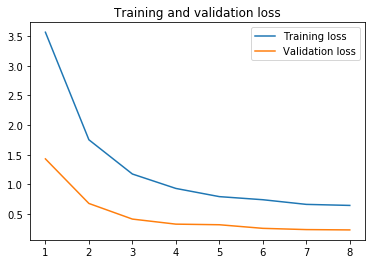

In [27]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')

plt.title('Training and validation loss')
plt.legend()

## Plot accuracy 

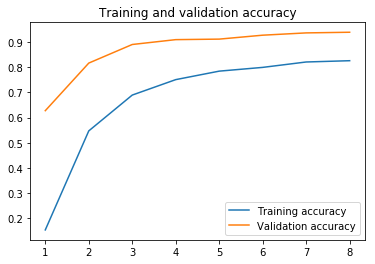

In [28]:

loss = history.history['acc']
val_loss = history.history['val_acc']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training accuracy')
plt.plot(epochs, val_loss, label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()

In [29]:
newdict = {}
for i in range(len(label)):
    newdict[i] = label[i]
print(newdict)

{0: '祝', 1: '铰', 2: '联', 3: '瑟', 4: '坑', 5: '挑', 6: '研', 7: '件', 8: '哀', 9: '静', 10: '儒', 11: '藐', 12: '瞪', 13: '拿', 14: '赡', 15: '逞', 16: '疫', 17: '蜘', 18: '山', 19: '舟', 20: '训', 21: '圣', 22: '毁', 23: '舶', 24: '煌', 25: '骂', 26: '假', 27: '轮', 28: '谍', 29: '榆', 30: '鼎', 31: '硅', 32: '眠', 33: '朴', 34: '半', 35: '迄', 36: '促', 37: '绎', 38: '觅', 39: '勺', 40: '戳', 41: '酵', 42: '撕', 43: '盂', 44: '弘', 45: '忘', 46: '砧', 47: '蝴', 48: '燎', 49: '题', 50: '尧', 51: '谭', 52: '订', 53: '矗', 54: '襟', 55: '踪', 56: '麓', 57: '规', 58: '挨', 59: '恤', 60: '聪', 61: '卞', 62: '丁', 63: '岔', 64: '租', 65: '充', 66: '各', 67: '猴', 68: '缩', 69: '枚'}


In [52]:
for i in range(len(Y_test)):
    itemindex = np.where(Y_test[i]==1)
    itemindex = itemindex[0][0]
    print(newdict[itemindex], itemindex)

44
硅 31
挑 5
圣 21
岔 63
弘 44
燎 48
蜘 17
砧 46
祝 0
谭 51
坑 4
盂 43
岔 63
谍 28
踪 55
硅 31
谭 51
矗 53
矗 53
充 65
鼎 30
瞪 12
谭 51
各 66
半 34
谍 28
恤 59
矗 53
坑 4
戳 40
赡 14
弘 44
各 66
榆 29
联 2
觅 38
尧 50
燎 48
榆 29
猴 67
拿 13
鼎 30
岔 63
哀 8
毁 22
迄 35
缩 68
矗 53
麓 56
忘 45
研 6
眠 32
谍 28
麓 56
缩 68
圣 21
毁 22
租 64
襟 54
研 6
件 7
规 57
件 7
踪 55
麓 56
哀 8
绎 37
舶 23
舶 23
骂 25
山 18
朴 33
觅 38
燎 48
促 36
毁 22
促 36
麓 56
题 49
缩 68
件 7
迄 35
骂 25
尧 50
瞪 12
租 64
轮 27
觅 38
轮 27
儒 10
尧 50
矗 53
疫 16
枚 69
舶 23
勺 39
丁 62
挑 5
迄 35
蝴 47
绎 37
襟 54
迄 35
赡 14
拿 13
忘 45
朴 33
鼎 30
订 52
戳 40
尧 50
谍 28
骂 25
朴 33
缩 68
半 34
迄 35
枚 69
研 6
赡 14
朴 33
铰 1
训 20
训 20
件 7
矗 53
谍 28
毁 22
榆 29
瞪 12
藐 11
瞪 12
联 2
哀 8
缩 68
戳 40
赡 14
硅 31
半 34
题 49
酵 41
挨 58
谍 28
逞 15
丁 62
襟 54
岔 63
坑 4
踪 55
瑟 3
卞 61
山 18
租 64
榆 29
盂 43
谭 51
丁 62
砧 46
鼎 30
充 65
朴 33
卞 61
坑 4
半 34
谭 51
忘 45
聪 60
藐 11
矗 53
毁 22
规 57
祝 0
铰 1
踪 55
尧 50
枚 69
谍 28
赡 14
祝 0
戳 40
蝴 47
朴 33
忘 45
坑 4
圣 21
哀 8
各 66
瞪 12
逞 15
联 2
充 65
联 2
迄 35
促 36
舶 23
铰 1
谍 28
瞪 12
勺 39
充 65
硅 31
假 26
逞 15
规 57
训 20
蜘

戳 40
勺 39
恤 59
研 6
岔 63
聪 60
拿 13
砧 46
丁 62
恤 59
硅 31
舟 19
联 2
山 18
谭 51
谍 28
尧 50
朴 33
逞 15
轮 27
榆 29
缩 68
疫 16
山 18
促 36
圣 21
踪 55
拿 13
轮 27
丁 62
弘 44
聪 60
毁 22
襟 54
圣 21
拿 13
训 20
弘 44
瑟 3
舟 19
鼎 30
砧 46
谭 51
挑 5
哀 8
充 65
促 36
山 18
燎 48
联 2
丁 62
充 65
谭 51
联 2
撕 42
假 26
毁 22
瑟 3
忘 45
藐 11
觅 38
绎 37
祝 0
缩 68
酵 41
麓 56
踪 55
硅 31
砧 46
鼎 30
疫 16
铰 1
毁 22
丁 62
瑟 3
蝴 47
训 20
鼎 30
眠 32
哀 8
研 6
坑 4
儒 10
矗 53
挨 58
租 64
觅 38
踪 55
铰 1
藐 11
题 49
赡 14
挑 5
迄 35
祝 0
弘 44
联 2
榆 29
猴 67
绎 37
眠 32
聪 60
促 36
促 36
榆 29
儒 10
恤 59
尧 50
挨 58
勺 39
朴 33
恤 59
燎 48
儒 10
挑 5
燎 48
尧 50
丁 62
坑 4
赡 14
蝴 47
藐 11
假 26
半 34
忘 45
聪 60
弘 44
研 6
坑 4
勺 39
绎 37
榆 29
铰 1
眠 32
眠 32
研 6
逞 15
酵 41
各 66
弘 44
猴 67
勺 39
迄 35
勺 39
铰 1
尧 50
矗 53
假 26
假 26
挑 5
充 65
缩 68
租 64
蜘 17
订 52
疫 16
瞪 12
觅 38
儒 10
各 66
半 34
挑 5
弘 44
铰 1
假 26
鼎 30
坑 4
充 65
猴 67
赡 14
榆 29
骂 25
戳 40
丁 62
充 65
瞪 12
硅 31
迄 35
恤 59
煌 24
勺 39
题 49
租 64
撕 42
蝴 47
榆 29
疫 16
蜘 17
谍 28
弘 44
迄 35
各 66
假 26
瑟 3
挑 5
骂 25
充 65
岔 63
联 2
恤 59
训 20
枚 69
逞 15
榆 29
绎 37
盂 43
静 

### Formula we use for determining accuracy:

$
Acc = \frac{\text{# of correct predictions}}{\text{total number of samples}}
$



In [30]:
pred = model.predict(X_test)
pred = (pred == pred.max(axis=1, keepdims=1)).astype(float)
print(len(pred))
acc = 0

for i in range(len(pred)):
    ind = np.where(pred[i] == 1)
    ind = ind[0][0]
    itemindex = np.where(Y_test[i]==1)
    itemindex = itemindex[0][0]
    if newdict[ind] == newdict[itemindex]:
        acc += 1
    #print("Predicted: ", newdict[ind], " Actual: ", newdict[itemindex])
print("Accuracy: ", acc/len(pred))

3850
Accuracy:  0.931948051948052


# Trying to predict our own handwriting

(427, 552)
4096
Predicted:  拿  Actual:  拿


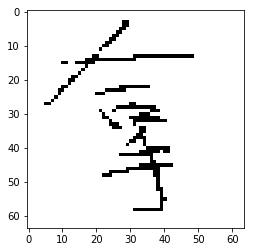

In [31]:
imgtest = Pil.open(r"C:\Users\caryw\Desktop\character1.jpg".encode('utf-8'))
print(imgtest.size)
gray = imgtest.convert('L')
bw = gray.point(lambda x: 0 if x<128 else 255, '1')
imgtest = np.array(bw.resize((64, 64)))
print(imgtest.size)
plt.imshow(imgtest, cmap='gray')
imgtest = imgtest.reshape(1, 64, 64, 1)


a = model.predict(imgtest)
a = (a == a.max(axis=1, keepdims=1)).astype(float)

for i in range(len(a)):
    ind = np.where(a[i] == 1)
    ind = ind[0][0]
    itemindex = np.where(Y_test[i]==1)
    itemindex = itemindex[0][0]
    print("Predicted: ", newdict[ind], " Actual: ", newdict[13]) 